In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import itertools
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import cv2
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
import threading


cudnn.benchmark = True
plt.ion()   # interactive mode

ModuleNotFoundError: No module named 'cv2'

In [300]:
# For straightforward datasets, sometimes you can make do with built-in PyTorch dataset objects.
# We want to apply automated data augmentations, which will be different for the training
# and eval scenarios

data_transforms = {
    x: transforms.Compose([
#         transforms.ToPILImage(),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.01, .5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    for x in ['train', 'val']
}

data_transforms['test'] = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [301]:
data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'val']}

In [302]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test', 'val']}

In [303]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 1588, 'test': 74, 'val': 144}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [304]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'
print(device)

cpu


In [305]:
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

True
True


In [306]:
# Let’s visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([4, 3, 200, 200])
tensor([18, 14,  9,  6])
torch.Size([3, 204, 810])


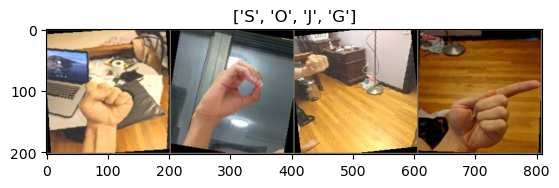

In [307]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title=[class_names[x] for x in classes])

In [309]:
# Now, let’s write a general function to train a model.
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [310]:
# Load a pretrained model and reset final fully connected layer for this particular classification problem.
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the correct device (when we have access to a GPU)
model_ft = model_ft.to(device)

In [311]:
# Let's set our loss function
criterion = nn.CrossEntropyLoss()

In [312]:
# Setup the optimizer to update the model parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

In [313]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [314]:
# Train and evaluate.
# It should take around 10 min on CPU. On GPU, it takes less than a minute.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


100%|█████████████████████████████████████████| 397/397 [00:51<00:00,  7.65it/s]


train Loss: 2.7739 Acc: 0.2311


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 20.63it/s]


val Loss: 1.6099 Acc: 0.5556

Epoch 1/9
----------


100%|█████████████████████████████████████████| 397/397 [00:49<00:00,  8.09it/s]


train Loss: 1.3836 Acc: 0.6297


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 21.70it/s]


val Loss: 0.7558 Acc: 0.7708

Epoch 2/9
----------


100%|█████████████████████████████████████████| 397/397 [00:49<00:00,  8.01it/s]


train Loss: 0.7221 Acc: 0.8287


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 22.28it/s]


val Loss: 0.5837 Acc: 0.8056

Epoch 3/9
----------


100%|█████████████████████████████████████████| 397/397 [00:50<00:00,  7.88it/s]


train Loss: 0.4228 Acc: 0.9030


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 20.54it/s]


val Loss: 0.4555 Acc: 0.8542

Epoch 4/9
----------


100%|█████████████████████████████████████████| 397/397 [00:52<00:00,  7.56it/s]


train Loss: 0.2989 Acc: 0.9377


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 19.59it/s]


val Loss: 0.5716 Acc: 0.7986

Epoch 5/9
----------


100%|█████████████████████████████████████████| 397/397 [00:55<00:00,  7.17it/s]


train Loss: 0.2306 Acc: 0.9578


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 19.55it/s]


val Loss: 0.4428 Acc: 0.8542

Epoch 6/9
----------


100%|█████████████████████████████████████████| 397/397 [00:53<00:00,  7.42it/s]


train Loss: 0.1648 Acc: 0.9673


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 19.24it/s]


val Loss: 0.4607 Acc: 0.8403

Epoch 7/9
----------


100%|█████████████████████████████████████████| 397/397 [00:53<00:00,  7.43it/s]


train Loss: 0.1219 Acc: 0.9798


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 18.81it/s]


val Loss: 0.4447 Acc: 0.8542

Epoch 8/9
----------


100%|█████████████████████████████████████████| 397/397 [00:53<00:00,  7.36it/s]


train Loss: 0.1135 Acc: 0.9824


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 19.97it/s]


val Loss: 0.4037 Acc: 0.8750

Epoch 9/9
----------


100%|█████████████████████████████████████████| 397/397 [00:52<00:00,  7.55it/s]


train Loss: 0.1111 Acc: 0.9843


100%|███████████████████████████████████████████| 36/36 [00:01<00:00, 18.70it/s]

val Loss: 0.4314 Acc: 0.8611

Training complete in 9m 0s
Best val Acc: 0.875000


In [315]:
def test_model(model):

    model.eval() # eval mode (not training anymore)
    running_corrects = 0

    # iterate over the test dataset
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # make predictions
        with torch.set_grad_enabled(False):
            outputs = model(inputs).squeeze(1)
            _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)

    # return accuracy
    return running_corrects.double() / dataset_sizes['test']

In [316]:
acc = test_model(model_ft)

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.73it/s]


In [317]:
acc

tensor(0.8514, dtype=torch.float64)

In [318]:
# frame_dir_path = "./data/frames/frame"
# max_frames = 2936

In [319]:
# for frame_no in tqdm(range(2937)):
#     frame_path = frame_dir_path + str(frame_no) + ".jpg"
#     image = Image.open(frame_path)
#     image = np.asarray(image)
#     image = data_transforms["test"](image)

#     print(class_names[torch.argmax(model_ft(image.unsqueeze(0)))])

In [323]:
# https://abauville.medium.com/display-your-live-webcam-feed-in-a-jupyter-notebook-using-opencv-d01eb75921d1
# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
def view(button):
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        
#         print(frame.shape)
        
        # crop and resize the frame
        crop_width, crop_height = 200, 200  # Adjust these values as per your requirements

        # Get the dimensions of the image
        height, width = frame.shape[:2]

        # Calculate coordinates for the crop
        start_x = (width - crop_width) // 2
        start_y = (height - crop_height) // 2

        # Crop the image
        cropped_image = frame[start_y:start_y + crop_height, start_x:start_x + crop_width]
        
        frame = cv2.resize(frame, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
    
        
        frame = cropped_image.astype(np.float32)
        
#         print(np.max(frame))
        
#         frame = rescale(image, 0.25)
        
        
#         print(frame.shape)
        new_frame = data_transforms["test"](frame / 255).unsqueeze(0)
#         print(torch.max(new_frame))
        
#         print(new_frame.shape)

        with torch.no_grad():
            pred = class_names[torch.argmax(model_ft(new_frame))] + ' ' + str(torch.max(nn.Softmax()(model_ft(new_frame))).item())
#         print(pred)
       
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(frame,  
                pred,  
                (50, 50),  
                font, 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
        
        _, frame = cv2.imencode('.jpeg', frame)
        
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

[ WARN:41@58428.318] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


None

Exception in thread Thread-48:
Traceback (most recent call last):
  File "/Users/akash/anaconda3/envs/acv-final/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/akash/anaconda3/envs/acv-final/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/f5/l11znykj5sj86z8zydv6sbtm0000gn/T/ipykernel_4104/849765437.py", line 30, in view
AttributeError: 'NoneType' object has no attribute 'shape'


## 